# 3 варіант
Вагін Олександр Вікторович

Полiномiальна регресiя, алгоритм градiєнтного спуску з моментом, MSE з регуляризацiєю за нормою L1.

# A

In [15]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import optuna

X_data = np.linspace(-1, 1, 100)
num_coef = 5
coef = [10, 2, 30, 4, 5]
y_data = 0
for i in range ( num_coef ) :
    y_data += coef[i]*np.power(X_data, i)
    y_data += np.random.randn (*X_data.shape)*1.5
    
tf.random.set_seed(42)

## У завданні потрібно виводити результати кожні 10 епох:

In [16]:
class Epoch10Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % 10 == 0:
            print(f'Epoch: {epoch}')
            print(f'Loss = {logs["loss"]:.4f}, RMSE = {logs["root_mean_squared_error"]:.4f}, MSE = {logs["mean_squared_error"]:.4f}')
            print(f'Validation Loss = {logs["val_loss"]:.4f}, Validation RMSE = {logs["val_root_mean_squared_error"]:.4f}, Val MSE = {logs["val_mean_squared_error"]:.4f}')


## Виведемо наші дані

[Text(0.5, 1.0, 'data'), Text(0.5, 0, 'X'), Text(0, 0.5, 'y')]

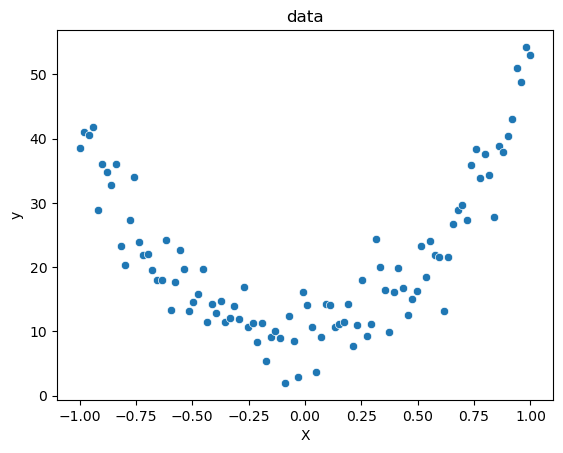

In [17]:
sns.scatterplot(x=X_data, y=y_data).set(title='data', xlabel='X', ylabel='y')

Як ми бачимо ми маємо доволі просте завдання з параболою

## Підготуємо дані

Стандартизуємо наші значення y, наша лінія потребує лише другий степінь поліному для гарного результату

Також створимо навчальний, валідаційний та тестовий датасет

Для усіх цих перетворень використаємо Scikit-learn

Також не забудемо навчити наш стандартизатор на навчальній виборці, щоб не було витечки данних

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

poly = PolynomialFeatures(degree=2)

X_train = poly.fit_transform(X_train.reshape(-1, 1))
X_train_val = poly.transform(X_train_val.reshape(-1, 1))
X_test = poly.transform(X_test.reshape(-1, 1))
X_val = poly.transform(X_val.reshape(-1, 1))
X = poly.transform(X_data.reshape(-1, 1))

stdscaler = StandardScaler()

y_train = stdscaler.fit_transform(y_train.reshape(-1, 1))
y_train_val = stdscaler.transform(y_train_val.reshape(-1, 1))
y_test = stdscaler.transform(y_test.reshape(-1, 1))
y_val = stdscaler.transform(y_val.reshape(-1, 1))
y = stdscaler.transform(y_data.reshape(-1, 1))

In [19]:
pd.Series(y.flatten()).describe()

count    100.000000
mean       0.016604
std        1.027368
min       -1.644177
25%       -0.778659
50%       -0.265064
75%        0.603383
max        2.860157
dtype: float64

### Переведемо усе у константні тензори з tensorflow

In [20]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

X_train = tf.constant(X_train, dtype=tf.float32)
X_train_val = tf.constant(X_train_val, dtype=tf.float32)
X_test = tf.constant(X_test, dtype=tf.float32)
X_val = tf.constant(X_val, dtype=tf.float32)

y_train = tf.constant(y_train, dtype=tf.float32)
y_train_val = tf.constant(y_train_val, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)
y_val = tf.constant(y_val, dtype=tf.float32)

## Підбір гіперпараметрів 

Шукаючи методи підбору гіперпараметрів для тензорфлоу я вирішив зупинитися на бібліотеці Optuna, мені її рекомендували друзі і судячи зі статей у інтернеті вона на даний момент "state-of-the-art" і не дуже складна у використанні для початківців

Приклади я брав на офіційному [гітхабі](https://github.com/optuna/optuna-examples/tree/main) для прикладів для бібліотеки 

In [21]:
def objective(trial):
    
    # будемо підбирати С для регуляризації шару
    c_lambda_1 = trial.suggest_float("lambda_1", 1e-5, 1, log=True)
    # Також по завданню потрібно підібрати швидкість навчання
    lrng_rate = trial.suggest_float("lrng_rate", 1e-5, 1, log=True)
    
    # Оскільки у нас дуже прости дані для нейронної мережі, то немає сенсу додавати більше 1 шару, модель може спокійно перенавчитися 
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(c_lambda_1))(inputs)
    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Використовувати будемо стохастичний градієнтний спуск з моментом, його параметр підбирати 
    # не будемо тому що від нього найбільше залежить швидкість збіжності алгоритму
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lrng_rate, momentum=0.3),
            loss='mean_squared_error',
            metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()])

    model.fit(X_train, y_train,
                    epochs=100,
                    verbose=0,
                    validation_data=(X_val, y_val))

    score = model.evaluate(X_val, y_val, verbose=0)
    return score[0]

In [22]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=15, timeout=600)

[I 2023-06-07 15:34:56,752] A new study created in memory with name: no-name-51edcf00-bfd5-4bfe-b125-bcc967245da3
[I 2023-06-07 15:35:01,281] Trial 0 finished with value: 0.11252050846815109 and parameters: {'lambda_1': 1.159030813360802e-05, 'lrng_rate': 0.1319538299337273}. Best is trial 0 with value: 0.11252050846815109.
[I 2023-06-07 15:35:06,159] Trial 1 finished with value: 1.6067246198654175 and parameters: {'lambda_1': 6.981481011546052e-05, 'lrng_rate': 0.00017210543074733126}. Best is trial 0 with value: 0.11252050846815109.
[I 2023-06-07 15:35:11,533] Trial 2 finished with value: 0.09646742790937424 and parameters: {'lambda_1': 1.0198357008947215e-05, 'lrng_rate': 0.02150540482716083}. Best is trial 2 with value: 0.09646742790937424.
[I 2023-06-07 15:35:15,908] Trial 3 finished with value: 1.5670533180236816 and parameters: {'lambda_1': 0.03437456732643874, 'lrng_rate': 0.00015048353397727164}. Best is trial 2 with value: 0.09646742790937424.
[I 2023-06-07 15:35:20,015] Tria

In [23]:
best_params = []

for key, value in study.best_trial.params.items():
    best_params.append(value)
    print("{}: {}".format(key, value))

lambda_1: 1.3371313807848528e-05
lrng_rate: 0.0272979966294372


## Навчання моделі
Тепер перенавчимо на додаткових зарезервованих даних

In [29]:
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(best_params[0]))(inputs)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=best_params[1], momentum=0.3),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_train_val, y_train_val,
                    epochs=100,
                    callbacks=[ Epoch10Callback(),
                               tf.keras.callbacks.ModelCheckpoint(filepath="model_2a",
                                                                  save_best_only=True, verbose=0,
                                                                  save_weights_only=True)],
                    verbose=0,
                    validation_data=(X_test, y_test))

y_pred_test = model.predict(X_test)
y_pred_full = model.predict(X)

Epoch: 0
Loss = 0.9015, RMSE = 0.9494, MSE = 0.9013
Validation Loss = 0.7500, Validation RMSE = 0.8659, Val MSE = 0.7498
Epoch: 10
Loss = 0.3533, RMSE = 0.5943, MSE = 0.3531
Validation Loss = 0.3474, Validation RMSE = 0.5892, Val MSE = 0.3472
Epoch: 20
Loss = 0.1572, RMSE = 0.3962, MSE = 0.1570
Validation Loss = 0.1924, Validation RMSE = 0.4383, Val MSE = 0.1921
Epoch: 30
Loss = 0.1190, RMSE = 0.3446, MSE = 0.1188
Validation Loss = 0.1722, Validation RMSE = 0.4148, Val MSE = 0.1720
Epoch: 40
Loss = 0.1189, RMSE = 0.3445, MSE = 0.1187
Validation Loss = 0.1893, Validation RMSE = 0.4349, Val MSE = 0.1891
Epoch: 50
Loss = 0.1136, RMSE = 0.3367, MSE = 0.1134
Validation Loss = 0.1734, Validation RMSE = 0.4162, Val MSE = 0.1732
Epoch: 60
Loss = 0.1145, RMSE = 0.3380, MSE = 0.1143
Validation Loss = 0.1796, Validation RMSE = 0.4235, Val MSE = 0.1794
Epoch: 70
Loss = 0.1133, RMSE = 0.3363, MSE = 0.1131
Validation Loss = 0.1816, Validation RMSE = 0.4259, Val MSE = 0.1814
Epoch: 80
Loss = 0.1085, 

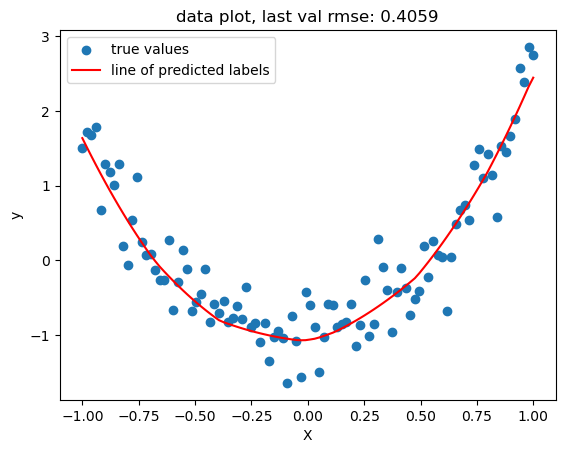

In [30]:
plt.scatter(x=X.numpy()[:, 1], y=y.numpy(), label='true values')
plt.plot(X.numpy()[:, 1], y_pred_full, c='red', label='line of predicted labels')
plt.title(f'data plot, last val rmse: {history.history["val_root_mean_squared_error"][-1]:.4f}')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

Як ми бачимо ми отримали дуже гарну модель для наших даних, другої степіні поліному, та 1 скритого шару виявилося достатньо для нашої задачі

Нагадаємо собі описові характеристики цільової змінної і подивимося на графіки:

In [31]:
pd.Series(y.numpy().flatten()).describe()

count    100.000000
mean       0.016604
std        1.027368
min       -1.644177
25%       -0.778659
50%       -0.265064
75%        0.603383
max        2.860157
dtype: float64

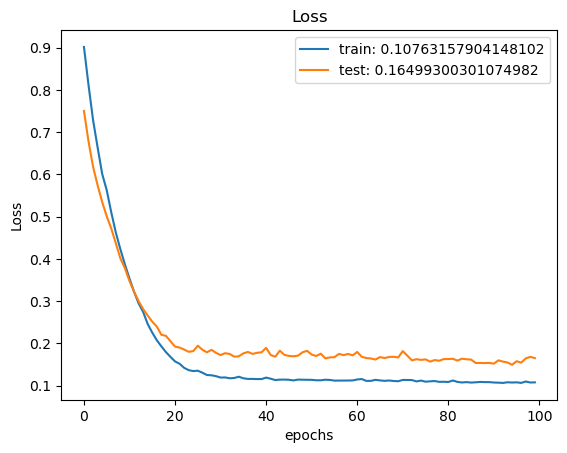

In [32]:
plt.plot(history.history['loss'], label=f"train: {history.history['loss'][-1]}")
plt.plot(history.history['val_loss'], label=f"test: {history.history['val_loss'][-1]}")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend()
plt.show()

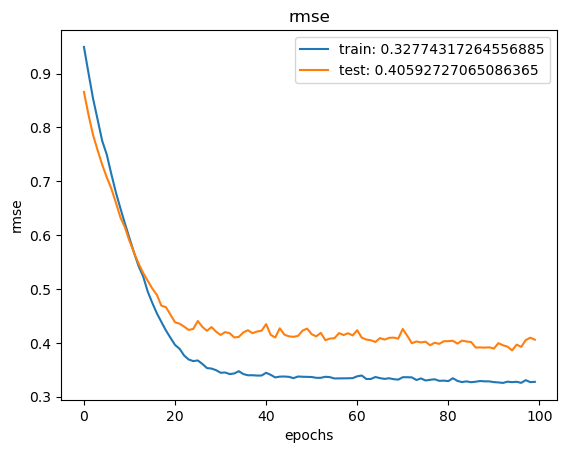

In [33]:
plt.plot(history.history['root_mean_squared_error'], label=f"train: {history.history['root_mean_squared_error'][-1]}")
plt.plot(history.history['val_root_mean_squared_error'], label=f"test: {history.history['val_root_mean_squared_error'][-1]}")
plt.xlabel("epochs")
plt.ylabel("rmse")
plt.title('rmse')
plt.legend()
plt.show()

Як ми бачимо з кривої змін метрик наша модель навчалася стабільно, без великих стрибків і ми отримали гарні результати MSE (це наша функція втрат) та RMSE, наше RMSE більше за MSE тому що їх значення менше 1

## Висновок:

Як ми бачимо наша модель гарно показала себе на данних, ми не потребували дуже складну та глибоку модель і отримали модель без перенавчання